# Surface area computation

This notebook showcases various ways to compute specific surface areas and interfacial areas of labelled phases based on dummy and real-world examples.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau
import tifffile

## Specific surface area validation

- cube - perfectly grid-aligned
- rotated cube (45° around z-axis)
- multiple cubes
- two {111}-planes in cube
- sphere

Let's start by creating the structures...

In [2]:
nx, ny, nz = [20, 20, 20]

cube = np.zeros((nx, ny, nz))
cube[5:-5,5:-5,5:-5] = 1

from scipy.ndimage import rotate
cube_rot = rotate(
    cube, angle=45.0, axes=(1, 0),  # rotate in (y, x) -> about z
    reshape=False,
    order=0,
    mode='constant',
    cval=0
).astype(np.uint8)

cubes = np.zeros((nx, ny, nz))
cubes[0:10, 0:10, 0:5] = 1
cubes[5:-5, 5:-5, 5:-5] = 2
cubes[0:10, 0:10, 15:] = 1
cubes[10:, 5:, 15:] = 3

diagonal = np.zeros((nx, ny, nz))
x, y, z = np.ogrid[:nx, :ny, :nz]
plane = (x+0.5)/nx + (y+0.5)/ny + (z+0.5)/nz
mask = (plane <= 1.05) | (plane > 2.0)
diagonal[mask] = 1

sphere = np.zeros((nx, ny, nz))
radius = np.min([nx,ny,nz])*0.5-3
x, y, z = np.ogrid[:nx, :ny, :nz]
distance_squared = (x - nx/2 + 0.5)**2 + (y - ny/2 + 0.5)**2 + (z - nz/2 + 0.5)**2
mask = distance_squared <= radius**2
sphere[mask] = 1

structures = {'cube': cube,
              'cube_rot': cube_rot,
              'multicube': cubes,
              'diagonal': diagonal,
              'sphere': sphere}

a_theo = {'cube': (2*(nx-10)*(ny-10)+2*(nx-10)*(nz-10)+2*(ny-10)*(nz-10))/(nx*ny*nz),
          'cube_rot': (2*(nx-10)*(ny-10)+2*(nx-10)*(nz-10)+2*(ny-10)*(nz-10))/(nx*ny*nz),
          'multicube': (2*(nx-10)*(ny-10)+(nx-10)*(nz-10)+(ny-10)*(nz-10))/(nx*ny*nz),
          'diagonal': np.sqrt(3)*nx**2/(nx*ny*nz),
          'sphere': 4*np.pi*radius**2/(nx*ny*nz)}

labels = {'gray': 1}

...and visualize the structures.

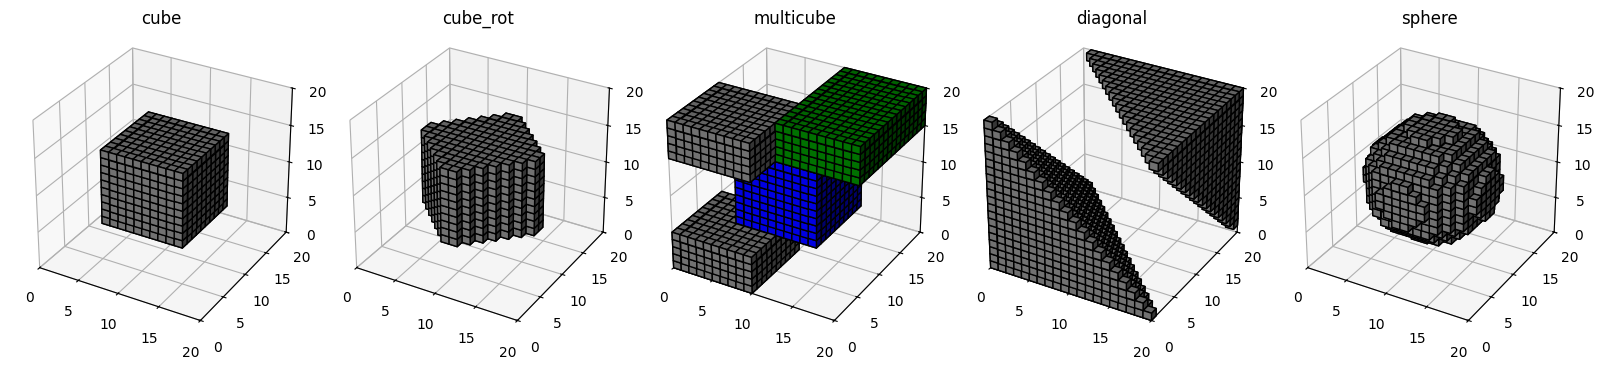

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 4), dpi=100)

i = 0
for key, value in structures.items():
    axes[i].remove()
    axes[i] = fig.add_subplot(1, 5, i + 1, projection='3d')

    axes[i].voxels(value==1, facecolors='gray', edgecolor='black', alpha=1.0)
    axes[i].voxels(value==2, facecolors='blue', edgecolor='black', alpha=1.0)
    axes[i].voxels(value==3, facecolors='green', edgecolor='black', alpha=1.0)
    axes[i].set_aspect('equal')
    axes[i].set_title(key)
    axes[i].set_xlim(0, nx)
    axes[i].set_ylim(0, ny)
    axes[i].set_zlim(0, nz)
    i = i + 1
plt.tight_layout()
plt.show()

The gray phase is labelled with `1` and will be used for the comparison of various surface areas computations. Note that already from the volume fractions we can see grid anisotropy i.e. the rotated cube now has 12% more voxels.

In [4]:
for key, struc in structures.items():
    print("Volume fraction of "+key+f": {tau.volume_fraction(struc, labels)['gray']:.4f}")

Volume fraction of cube: 0.1250
Volume fraction of cube_rot: 0.1400
Volume fraction of multicube: 0.1250
Volume fraction of diagonal: 0.3587
Volume fraction of sphere: 0.1840


In [5]:
a_faces = {}
a_marching = {}
a_gradient = {}

for key, struc in structures.items():
    a_faces[key] = tau.specific_surface_area(struc,
                                             method='face_counting',
                                             phases=labels)['gray']
    a_gradient[key] = tau.specific_surface_area(struc,
                                                method='gradient',
                                                phases=labels,
                                                smoothing=False)['gray']
    a_marching[key] = tau.specific_surface_area(struc,
                                                method='marching_cubes',
                                                phases=labels,
                                                smoothing=False,
                                                device='cpu')['gray']

print("Spec. surf. area:     faces         \t|      gradient      \t|   marching")
for key, struc in structures.items():
    print(key+f":   \t{a_faces[key]:.5f} ({((a_faces[key]-a_theo[key])/a_theo[key]*100):.2f} %)\t|"
        f"  {a_gradient[key]:.5f} ({(a_gradient[key]-a_theo[key])/a_theo[key]*100:.2f} %)\t|"
        f"  {a_marching[key]:.5f} ({(a_marching[key]-a_theo[key])/a_theo[key]*100:.2f} %)")

Spec. surf. area:     faces         	|      gradient      	|   marching
cube:   	0.07500 (0.00 %)	|  0.07085 (-5.53 %)	|  0.07051 (-5.98 %)
cube_rot:   	0.09800 (30.67 %)	|  0.07657 (2.10 %)	|  0.07624 (1.65 %)
multicube:   	0.05000 (0.00 %)	|  0.04823 (-3.54 %)	|  0.04219 (-15.61 %)
diagonal:   	0.14963 (72.77 %)	|  0.09402 (8.57 %)	|  0.07813 (-9.78 %)
sphere:   	0.11700 (52.01 %)	|  0.08378 (8.85 %)	|  0.08344 (8.41 %)


From the comparison of surface area computations we can see that face counting is exact for all cases where we have grid aligned structures (`cube` and `multicube`). The specific surface area of a sphere is overestimated by $50\%$ even in the limit of high voxel resolution as discussed by [Daubner et. al.](https://iopscience.iop.org/article/10.1149/1945-7111/ad9a07) and, similarly, the diagonal planes are overestimated by $\sqrt{3}-1 = 73.2\%$.

The `marching_cubes` algorithm and the `gradient` method introduce some errors for grid aligned cases (due to edge smoothing) but generally perform much better for curved surfaces as often encountered in porous microstructures. Especially in the context of battery electrodes, the spherical example is the most relevant comparison. Both the `marching_cubes` and the `gradient` method can be combined with a smoothing operation (convolution with a 3x3x3 Gaussian kernel) which further increases the accuracy for curved surfaces but leads to increased edge smoothing for all cuboid structures. Note that `smoothing=True` is the default option for the `specific_surface_area` function.

In [6]:
for key, value in structures.items():
    a_gradient[key] = tau.specific_surface_area(value, method='gradient', phases=labels)['gray']
    a_marching[key] = tau.specific_surface_area(value, method='marching_cubes', phases=labels, device='cpu')['gray']

print("Spec. surf. area:     gradient      \t|   marching")
for key, struc in structures.items():
    print(key+f":     \t{a_gradient[key]:.5f} ({(a_gradient[key]-a_theo[key])/a_theo[key]*100:.2f} %)\t|"
        f"  {a_marching[key]:.5f} ({(a_marching[key]-a_theo[key])/a_theo[key]*100:.2f} %)")

Spec. surf. area:     gradient      	|   marching
cube:     	0.06547 (-12.71 %)	|  0.06368 (-15.10 %)
cube_rot:     	0.07063 (-5.83 %)	|  0.06941 (-7.45 %)
multicube:     	0.04587 (-8.26 %)	|  0.03958 (-20.83 %)
diagonal:     	0.08502 (-1.83 %)	|  0.07626 (-11.94 %)
sphere:     	0.07770 (0.95 %)	|  0.07634 (-0.82 %)


## Interfacial area validation

Next, let's look at pairwise interfacial areas.
For now, only `face_counting` is implemented.

In the case of a binary structure, there will only be one interfacial area which must be equivalent to to respective specific surface areas. This can be easily shown:

In [7]:
print(tau.specific_surface_area(sphere, method='face_counting'))
print(tau.interfacial_areas(sphere, normalize=True))

{'0': 0.117, '1': 0.117}
{(0, 1): 0.117}


The multi-label cube is a good validation example for this function. Note that there is a `normalize = True` option to compute the specific interfacial areas in [1/m] while `normalize = False` returns the toal amount of counted faces.

In [8]:
tau.interfacial_areas(cubes, normalize = False)

{(0, 1): 325.0,
 (0, 2): 500.0,
 (0, 3): 200.0,
 (1, 2): 50.0,
 (1, 3): 25.0,
 (2, 3): 50.0}

These results are correct which can be easily confirmed by looking at the multi-cube structure in the figure above.

## Battery electrode example

In [9]:
structure = tifffile.imread('electrode.tif')
print("Stack shape:", structure.shape)
labels = {"pore":0, "NMC":1, "CBD":2}

Stack shape: (253, 253, 253)


Let's track the wall time of each method

In [10]:
import time
timer = []
timer.append(time.time())
print(tau.specific_surface_area(structure, phases=labels, method='face_counting', device='cuda'))
timer.append(time.time())
print(tau.specific_surface_area(structure, phases=labels, method='gradient', smoothing=False, device='cuda'))
timer.append(time.time())
print(tau.specific_surface_area(structure, phases=labels, method='gradient', smoothing=True, device='cuda'))
timer.append(time.time())
print(tau.specific_surface_area(structure, phases=labels, method='marching_cubes', smoothing=False, device='cpu'))
timer.append(time.time())
print(tau.specific_surface_area(structure, phases=labels, method='marching_cubes', smoothing=True, device='cpu'))
timer.append(time.time())

print(f"Face_counting: {timer[1]-timer[0]:.4f} s\n"
      f"Gradient w/o smoothing: {timer[2]-timer[1]:.4f} s\n"
      f"Gradient w smoothing: {timer[3]-timer[2]:.4f} s\n"
      f"Marching w/o smoothing: {timer[4]-timer[3]:.4f} s\n"
      f"Marching w smoothing: {timer[5]-timer[4]:.4f} s"
      )

{'pore': 0.31351890547506384, 'NMC': 0.15179072211744926, 'CBD': 0.3307823498387733}
{'pore': 0.17949838081687747, 'NMC': 0.10949625136089744, 'CBD': 0.1920918420748268}
{'pore': 0.10478981247511081, 'NMC': 0.09562062418717428, 'CBD': 0.10431124835026596}
{'pore': 0.22486792504787445, 'NMC': 0.11003817617893219, 'CBD': 0.2431361973285675}
{'pore': 0.11492584645748138, 'NMC': 0.09639179706573486, 'CBD': 0.12579435110092163}
Face_counting: 0.3551 s
Gradient w/o smoothing: 0.1065 s
Gradient w smoothing: 0.1455 s
Marching w/o smoothing: 7.3065 s
Marching w smoothing: 5.1581 s


From these results we can already see that the marching cubes method is more than an order of magnitude slower than the other methods.

Next we use the SNOW segmentation to identify all individual NMC particles

In [12]:
import porespy as ps

snow_labels = (ps.filters.snow_partitioning(structure == 1)).regions
print(f"Identified {np.unique(snow_labels).size} individual particles.")

0it [00:00, ?it/s]

Identified 1423 individual particles.


In [13]:
timer = []
timer.append(time.time())
surf = tau.specific_surface_area(snow_labels, method='face_counting', device='cuda')
timer.append(time.time())
surf = tau.specific_surface_area(snow_labels, method='gradient', smoothing=False, device='cuda')
timer.append(time.time())
surf = tau.specific_surface_area(snow_labels, method='gradient', smoothing=True, device='cuda')
timer.append(time.time())
surf = tau.specific_surface_area(snow_labels, method='marching_cubes', smoothing=False, device='cpu')
timer.append(time.time())
surf = tau.specific_surface_area(snow_labels, method='marching_cubes', smoothing=True, device='cpu')
timer.append(time.time())

print(f"Face_counting: {timer[1]-timer[0]:.4f} s\n"
      f"Gradient w/o smoothing: {timer[2]-timer[1]:.4f} s\n"
      f"Gradient w smoothing: {timer[3]-timer[2]:.4f} s\n"
      f"Marching w/o smoothing: {timer[4]-timer[3]:.4f} s\n"
      f"Marching w smoothing: {timer[5]-timer[4]:.4f} s"
      )

Face_counting: 0.4443 s
Gradient w/o smoothing: 3.2586 s
Gradient w smoothing: 3.8720 s
Marching w/o smoothing: 79.7743 s
Marching w smoothing: 78.1839 s


In [14]:
interfaces = tau.interfacial_areas(snow_labels, normalize=False)
count = 0
av_interface_area = 0
for pair, val in interfaces.items():
    if pair[0] != 0 and pair[1] != 0:
        count += 1
        av_interface_area += val
av_interface_area = av_interface_area / count
print(f"Average interfacial area between particles is {av_interface_area} voxel faces.")

Average interfacial area between particles is 111.6624803767661 voxel faces.
